# Load Dataset

In [1]:
#import library
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from collections import defaultdict
import re
from collections import defaultdict, Counter

C:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#load dataset
df = pd.read_csv("gaza_before_conflict.csv")
df.head()

,article_title,author,published_time,article_text
0,First Saudi ambassador to Palestine arrives in...,By Xinhua,"Published: Sep 27, 2023 09:58 AM",Saudi ambassador to Palestine Naif bin Bandar ...
1,"1,100 Gazan kidney patients facing drug shorta...",By Xinhua,"Published: Sep 21, 2023 11:02 AM",A young Palestinian patient receives treatment...
2,Mideast in Pictures: It's back-to-school day i...,By Xinhua,"Published: Aug 27, 2023 01:21 PM",Palestinian students are pictured in a classro...
3,Palestinians injured in clashes with Israeli s...,By Xinhua,"Published: Aug 22, 2023 11:05 AM",Palestinian protesters hurl stones at Israeli ...
4,Palestinian students participate in digital ex...,By Xinhua,"Published: Aug 17, 2023 10:13 AM",A Palestinian student participates in a digita...


In [3]:
df.shape

(30, 4)

In [4]:
#check and remove incomplete data
check_condition = (df['article_text'] == 'Article text not found') & (df['author'] == 'Author not found')
df = df[~check_condition]

In [5]:
df.shape

(28, 4)

# Disambiguation Handling using Rule Based Method

In [6]:
dict_df = pd.read_excel('dict_gaza.xlsx')
dict_df.head()

,variation,standard
0,Israel,Israel
1,Israeli,Israel
2,Jerusalem,Jerusalem
3,East Jerusalem,Jerusalem
4,Palestine,Palestine


In [7]:
word_dict = pd.Series(dict_df.standard.values, index=dict_df.variation).to_dict()
word_dict

{'Israel': 'Israel',
 'Israeli': 'Israel',
 'Jerusalem': 'Jerusalem',
 'East Jerusalem': 'Jerusalem',
 'Palestine': 'Palestine',
 'Palestinian': 'Palestine',
 'Palestinians': 'Palestine',
 'State of Palestine': 'Palestine',
 'Palestinian Nakba Day': 'Palestinian Nakba',
 'Palestinian Nakba': 'Palestinian Nakba',
 'Nakba Day': 'Palestinian Nakba',
 'Gaza': 'Gaza',
 'Gaza Strip': 'Gaza',
 'Gaza City': 'Gaza',
 'Southern Gaza': 'Gaza',
 'Southern Gaza Strip': 'Gaza',
 'Israeli-Palestinian': 'Palestinian-Israeli Conflict',
 'Palestinian-Israeli': 'Palestinian-Israeli Conflict',
 'Palestinian-Israeli Conflict': 'Palestinian-Israeli Conflict',
 'China': 'China',
 'Chinese': 'China',
 'Egyptian': 'Egypt',
 'EU': 'EU',
 'European': 'EU',
 'Europe': 'EU',
 'American': 'US',
 'Americans': 'US',
 'Lebanese': 'Lebanon',
 'Russian': 'Russia',
 'Syrian': 'Syria',
 'French': 'France',
 'Iranian': 'Iran',
 'Turkish': 'Turkey',
 'Saudi Arabia': 'Saudi Arabia',
 'Saudi': 'Saudi Arabia',
 'Arab': 'Saudi 

In [8]:
def standardize_text(text, word_dict):
    lower_word_dict = {key.lower(): value for key, value in word_dict.items()}
    sorted_keys = sorted(lower_word_dict.keys(), key=len, reverse=True)
    
    #pattern that matches any of the keys
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(key) for key in sorted_keys) + r')\b', re.IGNORECASE)
    
    def replace(match):
        word = match.group(0)
        lower_word = word.lower()
        return lower_word_dict.get(lower_word, word)
    
    #replace words in the text using the pattern and the replace function
    standardized_text = pattern.sub(replace, text)
    return standardized_text

In [9]:
text = """The conflict happen between Israeli and Palestinian in East Jerusalem in State of Palestine in Gaza Strip. Gaza City palestinian nakba day,
this israeli-palestinian and egyptian, palestinian-israeli conflict. in european and syrian and saudi. the west people, UN Security Council, UNRWA,
Security Council, GT, UN General assembly, Israel defense forces, UNSC, Communist Party of China Central Committee. Ministry of Health, Xinhua News Agency,
United Nations Relief and Works Agency for Palestine Refugees, putin, United Nations Security Council, biden, UN World Food Programme, UN Development Programme,
Palestinian Health Ministry, benjamin, adha, Palestinian Ministry of Health. Mediterranean Sea and Al - Sudairi. also Rizek Abdelja in PIJ and plo, Naif bin Bandar Al
Rizek Abdeljawad. Rizek Abdel. Rizek Abdelja.
Palestinian Islamic Ji.
Xinh. Xi is Xinh."""

In [10]:
standardized_text = standardize_text(text, word_dict)
print(standardized_text)

The conflict happen between Israel and Palestine in Jerusalem in Palestine in Gaza. Gaza Palestinian Nakba,
this Palestinian-Israeli Conflict and Egypt, Palestinian-Israeli Conflict. in EU and Syria and Saudi Arabia. the West people, UN, UN,
UN, Global Times, UN, IDF, UN, CPC Central Committee. Health Ministry, Xinhua,
UN, Vladimir Putin, UN, Joe Biden, UN, UN,
Health Ministry, Benjamin Netanyahu, Eid Al-Adha, Health Ministry. Mediterranean and Naif bin Bandar Al - Sudairi. also Rizek Abdel Jawad in Palestinian Islamic Jihad and Palestine Liberation Organization, Naif bin Bandar Al - Sudairi
Rizek Abdel Jawad. Rizek Abdel Jawad. Rizek Abdel Jawad.
Palestinian Islamic Jihad.
Xinhua. Xi Jinping is Xinhua.


In [11]:
df['article_text'] = df['article_text'].apply(lambda x: standardize_text(x, word_dict))
df.head()

,article_title,author,published_time,article_text
0,First Saudi ambassador to Palestine arrives in...,By Xinhua,"Published: Sep 27, 2023 09:58 AM",Saudi Arabia ambassador to Palestine Naif bin ...
1,"1,100 Gazan kidney patients facing drug shorta...",By Xinhua,"Published: Sep 21, 2023 11:02 AM",A young Palestine patient receives treatment a...
2,Mideast in Pictures: It's back-to-school day i...,By Xinhua,"Published: Aug 27, 2023 01:21 PM",Palestine students are pictured in a classroom...
3,Palestinians injured in clashes with Israeli s...,By Xinhua,"Published: Aug 22, 2023 11:05 AM",Palestine protesters hurl stones at Israel sol...
4,Palestinian students participate in digital ex...,By Xinhua,"Published: Aug 17, 2023 10:13 AM",A Palestine student participates in a digital ...


In [12]:
df.to_csv('Gaza_before_conflict_preprocessed.csv', index=False)

# NER using BERT

In [12]:
#load pretrained model and tokenizer
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [13]:
#create NER pipeline
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

In [14]:
#function to merge subwords
def merge_subwords(ner_results):
    merged_results = []
    for res in ner_results:
        if res['word'].startswith('##'):
            merged_results[-1]['word'] += res['word'][2:]
            merged_results[-1]['end'] = res['end']
        else:
            merged_results.append(res)
    return merged_results

In [16]:
#function to resolve inconsistent labels
def resolve_entity_labels(ner_results):
    entity_dict = defaultdict(lambda: defaultdict(int))
    
    for entity in ner_results:
        entity_text = entity['word']
        entity_label = entity['entity_group']
        entity_dict[entity_text][entity_label] += 1
    
    resolved_entities = {}
    for entity_text, labels in entity_dict.items():
        resolved_label = max(labels, key=labels.get)
        resolved_entities[entity_text] = (resolved_label, sum(labels.values()))
    
    return resolved_entities

#function to extract named entities
def extract_named_entities(text):
    ner_results = nlp(text)
    merged_results = merge_subwords(ner_results)
    #resolve inconsistent labels
    resolved_entities = resolve_entity_labels(merged_results)
    return resolved_entities

#function to consolidate entities
def consolidate_entities(entities):
    consolidated = defaultdict(lambda: defaultdict(int))
    partial_names = set()

    for entity, (entity_group, count) in entities.items():
        parts = entity.split()
        if len(parts) > 1:
            consolidated[entity_group][entity] += count
            #aggregate counts from shorter forms
            for part in parts:
                if part in entities and entities[part][0] == entity_group:
                    consolidated[entity_group][entity] += entities[part][1]
                    partial_names.add(part)
        else:
            if entity not in partial_names:
                consolidated[entity_group][entity] += count

    for part in partial_names:
        if part in consolidated[entity_group]:
            del consolidated[entity_group][part]

    flat_consolidated = {}
    for entity_group, entity_dict in consolidated.items():
        for name, count in entity_dict.items():
            flat_consolidated[name] = (entity_group, count)

    return flat_consolidated

#apply the functions to the dataset
ner_results_list = []
for text in df['article_text']:
    entities = extract_named_entities(text)
    consolidated_entities = consolidate_entities(entities)
    ner_results_list.append(consolidated_entities)

df['NER'] = ner_results_list
df.to_csv('BERT_NER_GAZA_BEFORE_CONFLICT.csv', index=False)

# Exploratory Data Analysis

In [19]:
#EDA
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [20]:
#words distribution named entities and non-entities
def count_words_distribution(text):
    named_entity_words = sum([count for entity_type, count in text.values()])
    return named_entity_words

df['Named_Entity_Words'] = df['NER'].apply(count_words_distribution)
df['total_words'] = df['article_text'].apply(len)
df['Non_Entity_Words'] = df['total_words'] - df['Named_Entity_Words']
df.head()

,article_title,author,published_time,article_text,NER,Named_Entity_Words,total_words,Non_Entity_Words
0,First Saudi ambassador to Palestine arrives in...,By Xinhua,"Published: Sep 27, 2023 09:58 AM",Saudi Arabia ambassador to Palestine Naif bin ...,"{'Saudi Arabia': ('LOC', 13), 'Palestine': ('L...",82,2673,2591
1,"1,100 Gazan kidney patients facing drug shorta...",By Xinhua,"Published: Sep 21, 2023 11:02 AM",A young Palestine patient receives treatment a...,"{'Palestine': ('LOC', 5), 'Gaza': ('MISC', 1),...",18,1804,1786
2,Mideast in Pictures: It's back-to-school day i...,By Xinhua,"Published: Aug 27, 2023 01:21 PM",Palestine students are pictured in a classroom...,"{'Palestine': ('LOC', 6), 'Gaza': ('LOC', 6), ...",26,1193,1167
3,Palestinians injured in clashes with Israeli s...,By Xinhua,"Published: Aug 22, 2023 11:05 AM",Palestine protesters hurl stones at Israel sol...,"{'Palestine': ('LOC', 18), 'Israel': ('LOC', 2...",69,2937,2868
4,Palestinian students participate in digital ex...,By Xinhua,"Published: Aug 17, 2023 10:13 AM",A Palestine student participates in a digital ...,"{'Palestine': ('LOC', 4), 'Gaza': ('LOC', 4), ...",16,501,485


In [21]:
total_words = df['total_words'].sum()
total_named_entity_words = df['Named_Entity_Words'].sum()
total_non_entity_words = total_words - total_named_entity_words
average_words_per_article = total_words / len(df)
percentage_named_entity_words = (total_named_entity_words / total_words) * 100

print("Total Words: ", total_words)
print("Total Named Entity Words: ", total_named_entity_words)
print("Total Non-Named Entity Words: ", total_non_entity_words)
print("Average number of words per article/length:", average_words_per_article)
print("Percentage of words in articles that are named entities:", percentage_named_entity_words)

Total Words:  57417
Total Named Entity Words:  1062
Total Non-Named Entity Words:  56355
Average number of words per article/length: 2050.6071428571427
Percentage of words in articles that are named entities: 1.84962641726318


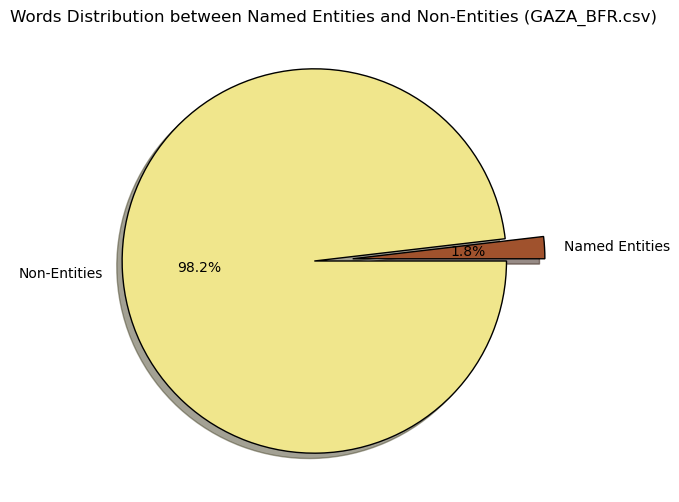

In [22]:
labels = ['Named Entities', 'Non-Entities']
sizes = [total_named_entity_words, total_non_entity_words]
colors = ['sienna','khaki']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', explode=(0.2, 0), shadow=True, wedgeprops={'edgecolor': 'black'})
plt.title('Words Distribution between Named Entities and Non-Entities (GAZA_BFR.csv)')
plt.axis('equal')
plt.show()

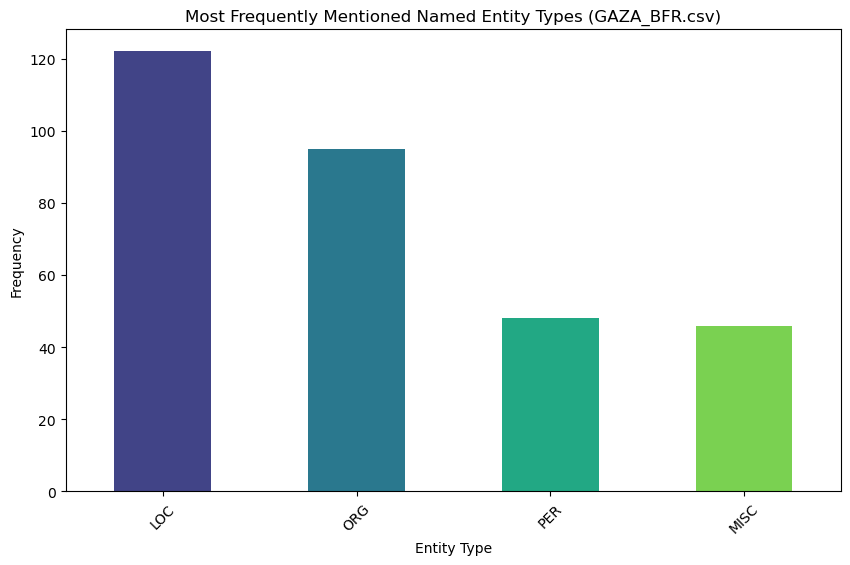

In [23]:
#most frequently mentioned named entity type
def count_entity_types(text):
    entity_types = [entity_type for entity_type, _ in text.values()]
    return entity_types

entity_types = df['NER'].apply(count_entity_types).explode().value_counts()
colors = sns.color_palette('viridis', len(entity_types))

plt.figure(figsize=(10, 6))
entity_types.plot(kind='bar', color=colors)
plt.title('Most Frequently Mentioned Named Entity Types (GAZA_BFR.csv)')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

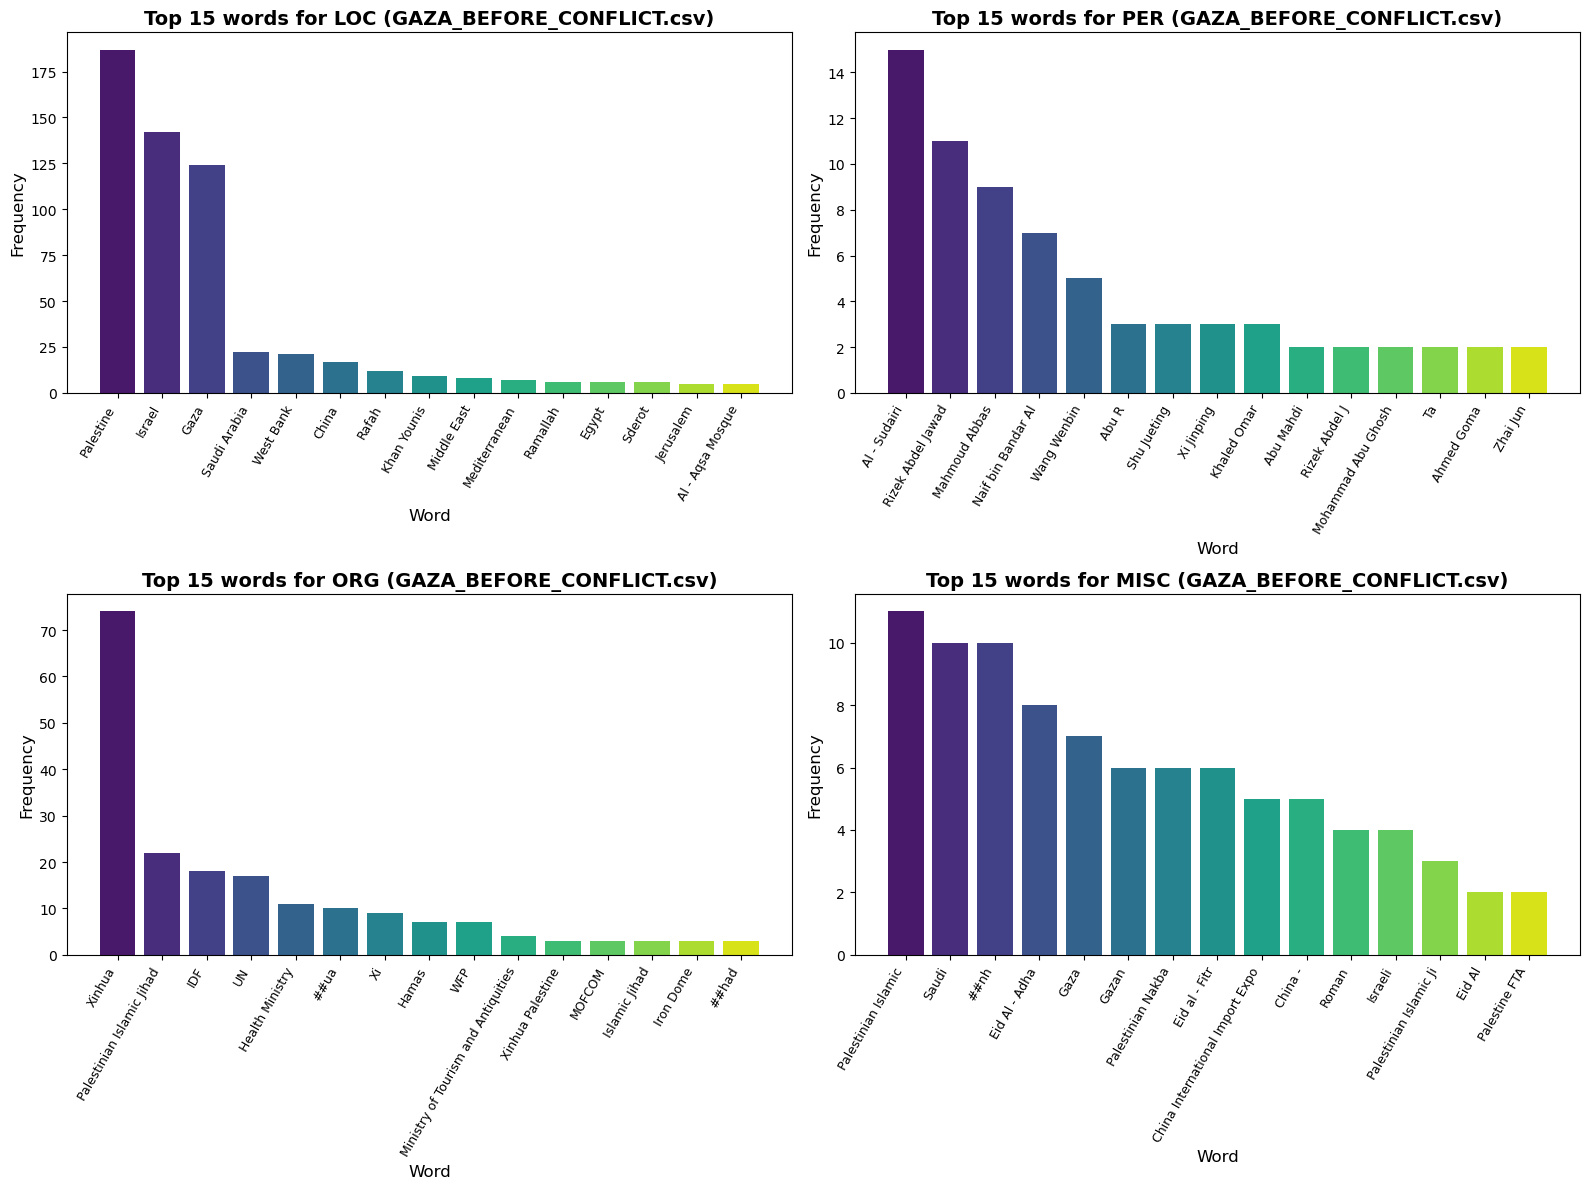

In [30]:
#top 15 words for each entity type
entity_words_dict = defaultdict(Counter)

for ner_dict in df['NER']:
    for word, (entity_type, count) in ner_dict.items():
        entity_words_dict[entity_type][word] += count

colors = sns.color_palette('viridis', 15)
plt.figure(figsize=(16, 12))

for i, (entity_type, words_counter) in enumerate(entity_words_dict.items(), 1):
    top_words = dict(words_counter.most_common(15))
    plt.subplot(2, 2, i)
    plt.bar(top_words.keys(), top_words.values(), color=colors)
    plt.title('Top 15 words for ' + entity_type + ' (GAZA_BEFORE_CONFLICT.csv)', fontsize=14, fontweight='bold')
    plt.xlabel('Word', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=60, fontsize=9, ha="right")

plt.tight_layout()
plt.show()

In [34]:
entity_words_dict = defaultdict(Counter)

for ner_dict in df['NER']:
    for word, (entity_type, count) in ner_dict.items():
        entity_words_dict[entity_type][word] += count

data = {'Entity Type': [], 'Word': [], 'Count': []}

for entity_type, words_counter in entity_words_dict.items():
    top_words = words_counter.most_common(40)
    for word, count in top_words:
        data['Entity Type'].append(entity_type)
        data['Word'].append(word)
        data['Count'].append(count)

df_top_words = pd.DataFrame(data)
excel_file_path = 'Gaza_Before_TopWords_v2.xlsx'
df_top_words.to_excel(excel_file_path, index=False)

print(f"Top words by entity type have been saved to {excel_file_path}.")

Top words by entity type have been saved to Gaza_Before_TopWords_v2.xlsx.


---

In [79]:
df = pd.read_csv('cekk.csv')
df.head()

,article_title,author,published_time,article_text
0,First Saudi ambassador to Palestine arrives in...,By Xinhua,"Published: Sep 27, 2023 09:58 AM",Saudi Arabia ambassador to Palestine Naif bin ...
1,"1,100 Gazan kidney patients facing drug shorta...",By Xinhua,"Published: Sep 21, 2023 11:02 AM",A young Palestine patient receives treatment a...
2,Mideast in Pictures: It's back-to-school day i...,By Xinhua,"Published: Aug 27, 2023 01:21 PM",Palestine students are pictured in a classroom...
3,Palestinians injured in clashes with Israeli s...,By Xinhua,"Published: Aug 22, 2023 11:05 AM",Palestine protesters hurl stones at Israel sol...
4,Palestinian students participate in digital ex...,By Xinhua,"Published: Aug 17, 2023 10:13 AM",A Palestine student participates in a digital ...


In [88]:
contains_xi = df['article_text'].str.contains('Xinh', case=False, na=False)
df_with_xi = df[contains_xi]
df_with_xi['article_text']

Series([], Name: article_text, dtype: object)